In [1]:
%matplotlib notebook

from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Pre-processing

In [2]:
# Read the data
data = pd.read_csv('C:/Users/vabalagon/Desktop/Meta/New Workflow/data/2 data for modeling (With PCA).csv')

# Get the features and target variable from the dataframe
X = data.drop(['Survey ID', 'Response Date', 'Likelihood to Recommend'], axis=1).to_numpy()
y = data['Likelihood to Recommend'].to_numpy()

# Split the data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y, test_size = 0.25, shuffle=True, random_state=42) #, stratify=y_smote

# Apply SMOTE oversampling to the TRAINING SET ONLY
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_smote))

Resampled dataset shape Counter({0: 8116, 2: 8116, 1: 8116})


# Random Forest

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

#### Searching for the best parameters

In [4]:
from sklearn.model_selection import RandomizedSearchCV

In [5]:
# n_estimators = [int(x) for x in np.linspace(start = 2, stop = 2000, num = 10)]

# # Number of features to consider at every split
# max_features = ['sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in range(1,20)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# # Random Forest Classifier
# rf = RandomForestClassifier(class_weight="balanced_subsample")

# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 200, 
#                                cv = 3, 
#                                verbose=3, 
#                                random_state=0, 
#                                n_jobs = -1,
#                                scoring='balanced_accuracy', 
#                                return_train_score=True)

# # Fit the random search model
# rf_random.fit(X_train_smote, y_train_smote)

# # Performance
# print("Test set balanced accuracy score:", balanced_accuracy_score(y_test, rf_random.predict(X_test)))

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Training set cross-validation balanced accuracy score: 0.8860945843283439
Test set balanced accuracy score: 0.7665557828694122


# Best parameters

* n_estimators: 600,
* min_samples_split: 2,
* min_samples_leaf: 2,
* max_features: 'sqrt',
* max_depth: 6,
* bootstrap: True

In [8]:
random_forest_clf = RandomForestClassifier(n_estimators= 668,
                                            min_samples_split= 5,
                                            min_samples_leaf= 4,
                                            max_features= 'sqrt',
                                            max_depth= 3,
                                            bootstrap= True,
                                          class_weight="balanced_subsample")
random_forest_clf.fit(X_train, y_train)

print("Test set balanced accuracy score:", balanced_accuracy_score(y_test, random_forest_clf.predict(X_test)))

Test set balanced accuracy score: 0.8058878427788286


##### Accuracy per class

In [9]:
y_pred = random_forest_clf.predict(X_test)

for y_i in np.unique(y_test)[::-1]:
    print('class: ', y_i)
    
    # Find the indices of y_i in the true labels
    indices_i = np.where(y_test == y_i)
    
    # Computes the accuracy
    print('Accuracy: ', str(round(np.sum(y_test[indices_i] == y_pred[indices_i])/ len(np.where(y_test==y_i)[0]), 3)))
    print( )

class:  2
Accuracy:  0.915

class:  1
Accuracy:  0.652

class:  0
Accuracy:  0.85



# Feature importance

['Satisfaction with the overall support experience (CSAT)' 'Score_1'
 'Overall Satisfaction with Agent (ASAT)'
 'Customer Effort Score (CES - Post Support)' 'Inquiry Resolved' 'Score_2'
 'Full Resolution Time' 'Ticket Handling Time' 'Solved Status']


<IPython.core.display.Javascript object>


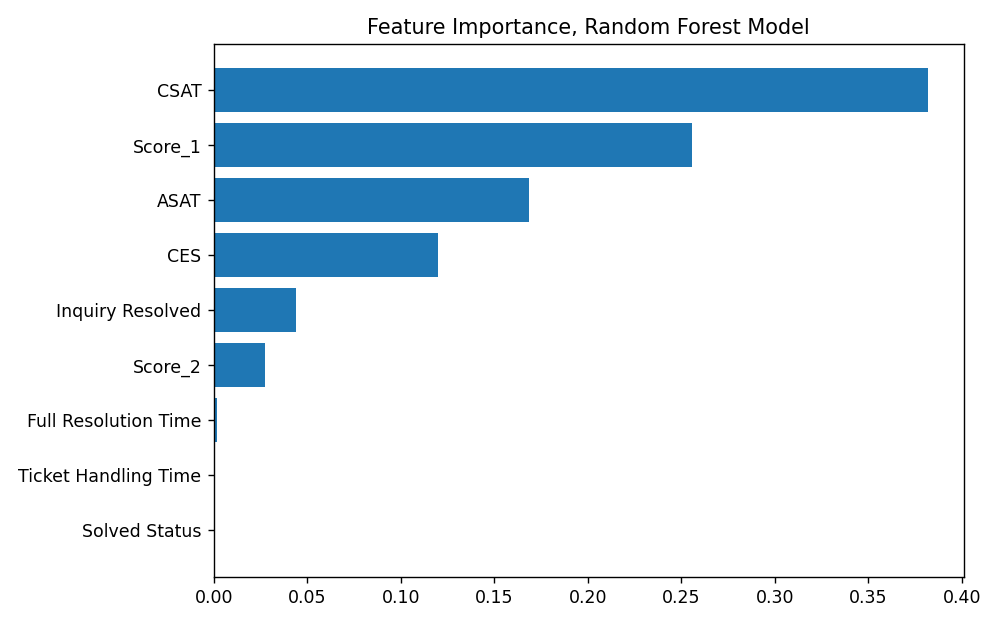

In [10]:
# Get the importances of each column 
importances = random_forest_clf.feature_importances_

# Arranges the indices such that the importances are arranged in descending order
indices = np.argsort(importances)[::-1]

# Find the corresponding columns
cols_feature_importance = data.drop(['Survey ID', 'Response Date', 'Likelihood to Recommend'], axis=1).columns[indices].to_numpy()
print(cols_feature_importance)
cols_feature_importance[0] = 'CSAT'
cols_feature_importance[3] = 'CES'
cols_feature_importance[2] = 'ASAT'

plt.figure(figsize=(8,5))

plt.barh(cols_feature_importance[::-1], importances[indices][::-1])
plt.title('Feature Importance, Random Forest Model')

plt.tight_layout()